# VQE calculation of the lowest energy of line molecule H4 Hamiltonian with R=[0.5,0.75,1.0,1.5,2.0]

In [1]:
import numpy as np
from qiskit import *
import scipy
import pylab
import copy

In [2]:
from qiskit.visualization import plot_histogram
from scipy import interpolate

In [3]:
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner

In [4]:
filename = ["H2_line_sto-3g_singlet_0.50.hdf5","H2_line_sto-3g_singlet_0.75.hdf5","H2_line_sto-3g_singlet_1.00.hdf5","H2_line_sto-3g_singlet_1.50.hdf5","H2_line_sto-3g_singlet_2.00.hdf5"]
jw_hamiltonian=[]
for i in range(len(filename)):
    
    molecular_data = MolecularData(filename=filename[i]) # load hdf5 file
    molecular_hamiltonian = get_fermion_operator(molecular_data.get_molecular_hamiltonian()) # get an instance of second quantized hamiltonian
    jw_hamiltonian.append(jordan_wigner(molecular_hamiltonian)) # get a Pauli operator representation of the hamiltonian
consst=[]
ham=[]
for op in jw_hamiltonian[0]: #return hamiltonian
    for key, const in op.terms.items():
        hampart=[]
        for nq, name_op in key:
            hampart.append([name_op,nq])
        ham.append(hampart)
        
for i in range(len(filename)):
    con=[]
    for op in jw_hamiltonian[i]:
        for key, const in op.terms.items():
            con.append(const)
    consst.append(con)

consst=np.array(consst) #array of constants

NQBITS = np.max(np.array([qbit for op in molecular_hamiltonian for terms, _const in op.terms.items() for qbit, name in terms]))+1
print("Number of qbits", NQBITS)

dime=np.array(2*np.ones(NQBITS), dtype='int')
phi0=np.zeros(2**NQBITS)
phi0[0]=(1.0)
#phi0=phi0.reshape(dime)
phi0=phi0.reshape(dime) #construct initial state

Number of qbits 4


In [5]:
def XGate(): return np.array([[0.0,1.0],[1.0,0.0]])

def YGate(): return np.array([[0.0,-1.0j],[1.0j,0.0]])

def ZGate(): return np.array([[1.0,0.0],[0.0,-1.0]])

def apply_gate(gate, qbit, phi):
    """
    Apply quantum gate to a statevector for a given qbit.
    Argument:
        gate: 2x2 matrix of the gate.
        qbit: index of qbit affected by the gate.
        phi: statevector in the form of 2x2x2x...x2 array.
    """
    nq = phi.ndim
    assert qbit<nq    
    idx = list(range(nq))
    idx[qbit] = nq
    return np.einsum(gate, [nq, qbit], phi, list(range(nq)), idx)

def apply_controlled_gate(control, gate, qbit, phi):
    """
    Apply controlled quantum gate to a statevector for a given qbit.
    Argument:
        control: control bit.
        gate: 2x2 matrix of the gate.
        qbit: index of qbit affected by the gate.
        phi: statevector in the form of 2x2x2x...x2 array.
    """
    nq = phi.ndim
    assert control<nq and qbit<nq and control!=qbit
    prefix = (slice(None),)*control
    psi0 = phi[prefix+(0,None)] # Action if control is zero.
    idx = list(range(nq))
    idx[qbit] = nq
    psi1 = np.einsum(gate, [nq, qbit], phi[prefix+(1,None)], list(range(nq)), idx) # Action if control 1.
    return np.concatenate((psi0,psi1), axis=control)

In [6]:
def Rx(theta): return np.cos(theta/2)*np.array([[1.0,0.0],[0.0,1.0]])-1j*np.sin(theta/2)*XGate()
def Ry(theta): return np.cos(theta/2)*np.array([[1.0,0.0],[0.0,1.0]])-1j*np.sin(theta/2)*YGate()
def Rz(theta): return np.cos(theta/2)*np.array([[1.0,0.0],[0.0,1.0]])-1j*np.sin(theta/2)*ZGate()

In [35]:
def anza_theta(theta,phi):
    for i in range(NQBITS):
        phi=apply_gate(Rx(theta[0][i][0]), i, phi)
        phi=apply_gate(Ry(theta[0][i][1]), i, phi)
        phi=apply_gate(Rz(theta[0][i][2]), i, phi)

    return phi

def anza_theta_depth(theta,phi,depth):
    for n in range(NQBITS-1):
        phi=apply_controlled_gate(n, XGate(), n+1, phi)
    apply_controlled_gate(NQBITS-1, XGate(), 0, phi) 
    for i in range(NQBITS):
        phi=apply_gate(Rx(theta[depth+1][i][0]), i, phi)
        phi=apply_gate(Ry(theta[depth+1][i][1]), i, phi)
        phi=apply_gate(Rz(theta[depth+1][i][2]), i, phi)        
    return phi

def meas_circ(ansatzz,ansatzz_depth,theta,phi):
    phi=ansatzz(theta,phi)
    for f in range(depth-1):
        phi=ansatzz_depth(theta,phi,f)
    return phi

def inner(a,b):# return np.sum(np.conj(a), b)
    return np.dot(np.conj(a.flatten()), b.flatten())

def evaluate_average(theta):
    theta=np.reshape(theta,(1+depth,NQBITS,3))
    phi=copy.copy(phi0)
    phi=meas_circ(anza_theta,anza_theta_depth,theta,phi)
    phi_right=copy.copy(phi)
    E=0
    for i in range(len(consst[rr])):
        phi_right=copy.copy(phi)
        for g in range(len(ham[i])):
            if ham[i][g][0]=='Z':
                phi_right=apply_gate(ZGate(),ham[i][g][1],phi_right)
            if ham[i][g][0]=='X':
                phi_right=apply_gate(XGate(),ham[i][g][1],phi_right)
            if ham[i][g][0]=='Y':
                phi_right=apply_gate(YGate(),ham[i][g][1],phi_right)
        E=E+np.real(consst[rr][i]*inner(phi,phi_right))
    return E

In [8]:
def chan_arg(theta,i,ang):
    #return theta_i=theta_i+ang in massive theta
    aan=copy.copy(theta)
    aan[i]=aan[i]+ang
    return aan

pi=np.pi/2

def jacob(theta):
    lenth=len(theta)
    jacobian=np.zeros(lenth)
    
    for i in range(lenth):
        jacobian[i]=0.5*(evaluate_average(chan_arg(theta,i,pi/2))-evaluate_average(chan_arg(theta,i,-pi/2)))
    return(jacobian)

In [9]:
R=[0.5,0.75,1.0,1.5,2.0]

In [44]:
depth=4
#'SLSQP'
#'COBYLA'
x0=np.random.random((NQBITS*3*(1+depth),1))
Energ_vqe=np.zeros(len(R))
for rr in range(len(R)):
    ans=scipy.optimize.minimize(fun=evaluate_average, x0=x0, method='SLSQP',tol=10**(-4),jac=jacob)
    Energ_vqe[rr]=ans.fun
    print('step ', rr, 'with R=', R[rr], 'energy=', Energ_vqe[rr], '№int=',ans.nfev)
    #print(ans)
Energ_vqe

step  0 with R= 0.5 energy= -1.0529241883298304 №int= 17
step  1 with R= 0.75 energy= -1.133989855166854 №int= 18
step  2 with R= 1.0 energy= -1.1008509538265483 №int= 46
step  3 with R= 1.5 energy= -0.9970859870919953 №int= 41
step  4 with R= 2.0 energy= -0.9481456451797406 №int= 58


array([-1.05292419, -1.13398986, -1.10085095, -0.99708599, -0.94814565])

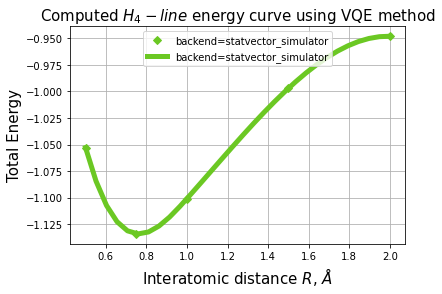

In [46]:
f1 = interpolate.interp1d(R,Energ_vqe, kind =  'cubic')
xnew = np.linspace(0.5, 2, 30)
pylab.plot(R,Energ_vqe,'D',xnew,f1(xnew),color=[107/255,200/255,35/255], linewidth=5, label='backend=statvector_simulator')

pylab.xlabel('Interatomic distance $R$, $\AA$', fontsize=15)
pylab.ylabel('Total Energy', fontsize=15)
pylab.grid()
pylab.title("Computed $H_4 -line$ energy curve using VQE method", fontsize=15)
pylab.legend(loc='upper center')

# Numeric calculation of the lowest energy of line molecule H4 Hamiltonian with R=[0.5,0.75,1.0,1.5,2.0]

In [13]:
Zg=np.array([[1,0],[0,-1]])
Xg=np.array([[0,1],[1,0]])
Yg=np.array([[0,-1j],[1j,0]])
Ig=np.array([[1,0],[0,1]])

In [14]:
Ed=[]
for i in range(NQBITS):
    Ed.append(Ig)
Ed=np.array(Ed, dtype='complex')
Hamiltonian_in_form=[]
for n in range(len(ham)):
    string=copy.copy(Ed)
    for g in range(len(ham[n])):
        if ham[n][g][0]=='Z':
            string[ham[n][g][1]]=Zg
        if ham[n][g][0]=='X':
            string[ham[n][g][1]]=Xg
        if ham[n][g][0]=='Y':
            string[ham[n][g][1]]=Yg
        else:
            pass
    Hamiltonian_in_form.append(string)
    del string
Hamiltonian_in_form=np.array(Hamiltonian_in_form)


In [15]:
len(Hamiltonian_in_form)

15

In [17]:
def built14dem(Hamil, qoef,r):
    H=np.zeros((2**NQBITS,2**NQBITS))
    for n in range(len(Hamiltonian_in_form)):
        a=Hamil[n][0]
        for m in range(NQBITS-1):
            a=np.kron(Hamil[n][m+1],a)
        a=qoef[r][n]*a
        H=H+a
        del a
        #if n % 20==0:
        #    print(n)
    
    return H

In [18]:
Energy_theory=np.zeros(len(R))
for r in range(len(R)):
    Energy_theory[r]=np.linalg.eigvalsh(built14dem(Hamiltonian_in_form, consst,r))[0]
    print(Energy_theory[r])

-1.0551597944706241
-1.1371170673457307
-1.1011503302326187
-0.9981493534714101
-0.9486411121761862


In [19]:
Energy_theory

array([-1.05515979, -1.13711707, -1.10115033, -0.99814935, -0.94864111])

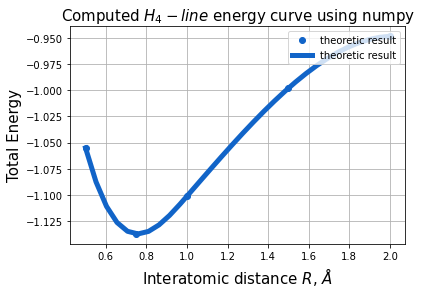

In [20]:
f2 = interpolate.interp1d(R,Energy_theory, kind = 'cubic')
pylab.plot(R,Energy_theory,'o',xnew,f2(xnew),color=[17/255,100/255,200/255], linewidth=5, label='theoretic result')


pylab.xlabel('Interatomic distance $R$, $\AA$', fontsize=15)
pylab.ylabel('Total Energy', fontsize=15)
pylab.grid()
pylab.title("Computed $H_4 - line$ energy curve using numpy", fontsize=15)
pylab.legend(loc='upper right')

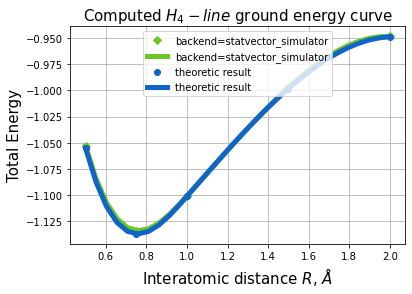

In [45]:
from scipy import interpolate
f1 = interpolate.interp1d(R,Energ_vqe, kind =  'cubic')
f2 = interpolate.interp1d(R,Energy_theory, kind = 'cubic')
xnew = np.linspace(0.5, 2,30)
print(f2)
pylab.plot(R,Energ_vqe,'D',xnew,f1(xnew),color=[107/255,200/255,35/255], linewidth=5, label='backend=statvector_simulator')
pylab.plot(R,Energy_theory,'o',xnew,f2(xnew),color=[17/255,100/255,200/255], linewidth=5, label='theoretic result')

pylab.xlabel('Interatomic distance $R$, $\AA$', fontsize=15)
pylab.ylabel('Total Energy', fontsize=15)
pylab.grid()
pylab.title("Computed $H_4 -line$ ground energy curve", fontsize=15)
pylab.legend(loc='upper center')